In [1]:
// %install-location $cwd/swift-install
// %install '.package(path: "$cwd/FastaiNotebook_10_mixup_ls")' FastaiNotebook_10_mixup_ls
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_09_optimizer")' FastaiNotebook_09_optimizer

Installing packages:
	.package(path: "/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_09_optimizer")
		FastaiNotebook_09_optimizer
With SwiftPM flags: []
Working in: /tmp/tmph3psb9x2/swift-install
/home/jmd/swift/usr/bin/swift-build: /home/jmd/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jmd/swift/usr/lib/swift/linux/libFoundationNetworking.so)
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [2]:
// export
import Path
import TensorFlow

In [3]:
// import FastaiNotebook_10_mixup_ls
import FastaiNotebook_09_optimizer

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [5]:
let path = downloadImagenette()

In [6]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])

In [7]:
let sd = SplitData(il) {grandParentSplitter(fName: $0, valid: "val")}

In [8]:
var procLabel = CategoryProcessor()

In [9]:
let sld = makeLabeledData(sd, fromFunc: parentLabeler, procLabel: &procLabel)

In [10]:
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor, bs: 128)

In [11]:
let data = transformData(rawData) { openAndResize(fname: $0, size: 128) }

In [12]:
let batch = data.train.oneBatch()!

In [13]:
print(batch.xb.shape)
print(batch.yb.shape)

[128, 128, 128, 3]
[128]


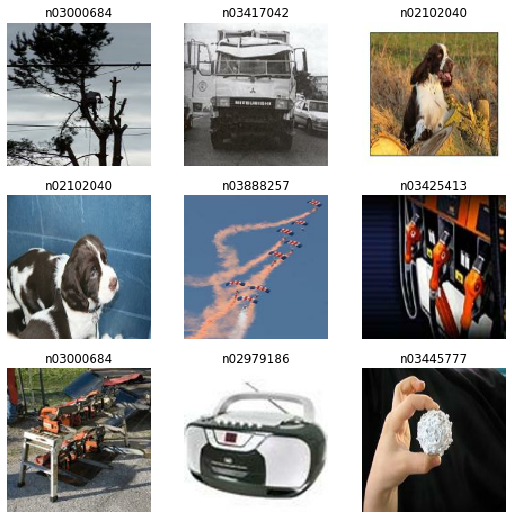

In [14]:
let labels = batch.yb.scalars.map { procLabel.vocab![Int($0)] }
showImages(batch.xb, labels: labels)

In [15]:
//export
public struct ConvLayer: Layer {
    public var bn: FABatchNorm<Float>
    public var conv: FANoBiasConv2D<Float>
    
    public init(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 1, zeroBn: Bool = false, act: Bool = true){
        bn = FABatchNorm(featureCount: cOut)
//      "activation: act ? relu : identity" fails on 0.3.1, so we use if/else
        if act {conv = FANoBiasConv2D(cIn, cOut, ks: ks, stride: stride, activation: relu)}
        else   {conv = FANoBiasConv2D(cIn, cOut, ks: ks, stride: stride, activation: identity)}
        if zeroBn { bn.scale = Tensor(zeros: [cOut]) }
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        // TODO: Work around https://bugs.swift.org/browse/TF-606
        return bn.forward(conv.forward(input))
    }
}

In [16]:
//export
public struct MaybeAvgPool2D: ParameterlessLayer {
    @noDerivative let poolSize: (Int, Int, Int, Int)
    @noDerivative let strides: (Int, Int, Int, Int)
    @noDerivative let padding: Padding
    @noDerivative public var isOn: Bool
    
    @differentiable public func callAsFunction(_ input: TF) -> TF { 
        return isOn ? avgPool2D(input, filterSize: poolSize, strides: strides, padding: padding) : input
    }
    
    public init(_ sz: Int, padding: Padding = .valid) {
        isOn = (sz>1)
        poolSize = (1, sz, sz, 1)
        strides = (1, sz, sz, 1)
        self.padding = padding
    }
}

In [17]:
//export
public struct MaybeConv: Layer {
    var conv: ConvLayer
    @noDerivative public var isOn: Bool
    
    @differentiable public func callAsFunction(_ input: TF) -> TF { 
        return isOn ? conv(input) : input
    }
    
    public init(_ cIn: Int, _ cOut: Int) {
        isOn = (cIn > 1) || (cOut > 1)
        conv = ConvLayer(cIn, cOut, ks: 1, act: false)
    }
}

In [18]:
//export
public struct ResBlock: Layer {
    public var convs: [ConvLayer]
    public var idConv: MaybeConv
    public var pool: MaybeAvgPool2D
    
    public init(_ expansion: Int, _ ni: Int, _ nh: Int, stride: Int = 1){
        let (nf, nin) = (nh*expansion,ni*expansion)
        convs = (expansion==1) ? [
            ConvLayer(nin, nh, ks: 3, stride: stride),
            ConvLayer(nh, nf, ks: 3, zeroBn: true, act: false)
        ] : [
            ConvLayer(nin, nh, ks: 1),
            ConvLayer(nh, nh, ks: 3, stride: stride),
            ConvLayer(nh, nf, ks: 1, zeroBn: true, act: false)
        ]
        idConv = nin==nf ? MaybeConv(1,1) : MaybeConv(nin, nf)
        pool = MaybeAvgPool2D(stride)
    }
    
    @differentiable
    public func callAsFunction(_ inp: TF) -> TF {
        return relu(convs(inp) + idConv(pool(inp)))
    }
    
}

In [19]:
//export
func makeLayer(_ expansion: Int, _ ni: Int, _ nf: Int, _ nBlocks: Int, stride: Int) -> [ResBlock] {
    return Array(0..<nBlocks).map { ResBlock(expansion, $0==0 ? ni : nf, nf, stride: $0==0 ? stride : 1) }
}

In [20]:
//export
public struct XResNet: Layer {
    public var stem: [ConvLayer]
    public var maxPool = MaxPool2D<Float>(poolSize: (3,3), strides: (2,2), padding: .same)
    public var blocks: [ResBlock]
    public var pool = GlobalAvgPool2D<Float>()
    public var linear: Dense<Float>
    
    public init(_ expansion: Int, _ layers: [Int], cIn: Int = 3, cOut: Int = 1000){
        var nfs = [cIn, (cIn+1)*8, 64, 64]
        stem = (0..<3).map{ ConvLayer(nfs[$0], nfs[$0+1], stride: $0==0 ? 2 : 1)}
        nfs = [64/expansion,64,128,256,512]
        blocks = layers.enumerated().map { (i,l) in 
            return makeLayer(expansion, nfs[i], nfs[i+1], l, stride: i==0 ? 1 : 2)
        }.reduce([], +)
        linear = Dense(inputSize: nfs.last!*expansion, outputSize: cOut)
    }
    
    @differentiable
    public func callAsFunction(_ inp: TF) -> TF {
        return inp.compose(stem, maxPool, blocks, pool, linear)
    }
}

In [21]:
//export
public func xresnet18 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [2, 2, 2, 2], cIn: cIn, cOut: cOut) }
public func xresnet34 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
public func xresnet50 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
public func xresnet101(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 23, 3], cIn: cIn, cOut: cOut) }
public func xresnet152(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 8, 36, 3], cIn: cIn, cOut: cOut) }

In [22]:
func modelInit() -> XResNet { return xresnet18(cOut: 10) }

In [23]:
let optFunc: (XResNet) -> StatefulOptimizer<XResNet> = adamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 1e-2, eps: 1e-6)

In [24]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)

In [25]:
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegate(learner.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))

In [26]:
learner.addOneCycleDelegates(1e-3, pctStart: 0.5)
learner.fit(5)

Epoch 0: [1.3493787, 0.556]                                                     
Epoch 1: [0.9582423, 0.698]                                                     
Epoch 2: [0.78327894, 0.754]                                                    
Epoch 3: [0.5364633, 0.856]                                                     
Epoch 4: [0.44816667, 0.868]                                                    


In [27]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"11_imagenette.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
